<a href="https://colab.research.google.com/github/SirMacho2/sprite_sgdk_converter/blob/main/Sgdk_sprite_converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variaveis de entrada 
modifique as variaveis para cada sprites




*   **pasta_dos_sprites** = pasta onde vão estar as imagens de cada sprite
*   **arquivo_de_saida** = nome do arquivo de saída
*   **backgrauond color** = [r g b]
*   **numero_de_cores** = numero de cores da saida inclue o background
*   **limitar_cores** = marque para limitar a quantidade de cores





In [1]:
#@title Variaveis de entrada
pasta_dos_sprites = "/content/terry" #@param {type:"string"}
arquivo_de_saida = "terry" #@param {type:"string"}
background_color = [248, 0, 248] #@param {type:"raw"}
numero_de_cores =  10#@param {type:"integer"}
limitar_cores = False #@param {type:"boolean"}
autodetect_backgroud_color = True #@param {type:"boolean"}

Importação das Bibiotecas



In [2]:
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import os
import numpy as np
from PIL import Image
import copy

Funções:

In [3]:
def load_images_from_folder(folder):
  images = []
  files = os.listdir(folder)
  files.sort()
  for filename in files:
    img = cv2.imread(os.path.join(folder,filename))
    if img is not None:
      images.append(img)
  return images

def convert_tiles ( min, max, x_y = 'x'):
  if (max - min) % 8 != 0:
    if x_y == 'x':
      max = max + 8 - (max - min) % 8
    else:
      min = min - 8+ (max - min) % 8
  if x_y == 'x':
    return max
  else:
    return min

def find_bounds(imgs):
  xmin =len(imgs[0][0])
  xmax = 0
  ymin =len(imgs[0])
  ymax = 0
  for img in imgs:
    for i in range(len(img)):
      for j in range(len(img[i])):
          if not np.all(img[i][j] == background_color):
            if j < xmin:
              xmin = j
            if j > xmax:
              xmax = j
            if i < ymin:
              ymin = i
            if i > ymax:
              ymax = i
  return xmin, xmax+1, ymin, ymax+1

def crop_images(imgs, xmin, xmax, ymin, ymax):
  imgs_crop = []
  if ymin < 0:
    pixel_array = np.full((-ymin, xmax-xmin, 3), background_color, dtype=np.uint8)
    for img in imgs:
      img = cv2.vconcat(pixel_array, img)
    ymin = 0
  
  ximg = tuple(imgs[0].shape[1::-1])[0]
  if xmax > ximg:
    pixel_array = np.full((ymax - ymin, xmax-ximg, 3), background_color, dtype=np.uint8)
    for img in imgs:
      img = cv2.hconcat(img, pixel_array)
                

  for img in imgs:
    imgs_crop.append(img[ymin:ymax, xmin:xmax])
  return imgs_crop

def save_imgs(imgs):
  i = 0
  for img in imgs:
    cv2.imwrite('/content/output/' + str(i) + '.png', img)
    i = i + 1

def concat_img(imgs):
  return cv2.hconcat(imgs)

def save_result(img, name, sprinte_count):
  if not os.path.exists('/content/output/'):
    os.makedirs('/content/output/')
  cv2.imwrite('/content/output/' + str(name) + '.png', img)

def show_imgs(imgs):
  for img in imgs:
    cv2_imshow(img)
    print(tuple(img.shape[1::-1]))

def change_bg(img):
  if not np.all([ 255, 0, 255] == background_color):
    return modify_color(img, background_color, [ 255, 0, 255])
  return img
    
                                        

def convert_colors(image, k):
    i = np.float32(image).reshape(-1,3)
    condition = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,20,1.0)
    ret,label,center = cv2.kmeans(i, k , None, condition,10,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    final_img = center[label.flatten()]
    final_img = final_img.reshape(image.shape)
    return final_img

def count_colors(img):
  unique, counts   = np.unique(img.reshape(-1, img.shape[-1]), axis=0, return_counts=True)
  return len(counts)

def modify_color(img, color_before, color_after):
  color_change = np.copy(img)
  for i in range(len(img)):
        for j in range(len(img[i])):
            if np.all(img[i][j] == color_before):
              color_change[i][j] = color_after
  return color_change

def get_pallet(img):
  unique, counts   = np.unique(img.reshape(-1, img.shape[-1]), axis=0, return_counts=True)
  pal = np.full((20, 1, 3), [0, 0, 0], dtype=np.uint8)
  for color in unique:
    pixel_array = np.full((20, 20, 3), color, dtype=np.uint8)
    pal = np.concatenate((pal, pixel_array), axis=1)
  return unique, pal

def save_result2(img, name, sprinte_count):
  if not os.path.exists('/content/output/'):
    os.makedirs('/content/output/')
  # cv2.imwrite('/content/output/' + str(name) + '.png', img)


def save_8bpp(img, name):
  if not os.path.exists('/content/output/'):
    os.makedirs('/content/output/')
  img_path = '/content/output/' + str(name) + '.png'
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = Image.fromarray(img)
  palette = convert_palette(img)
  if 768 % len(palette) != 0:
    raise Exception('error', 'invalid palette size')
  
  scale = 768//len(palette)
  
  img1 = img.convert(mode='RGB')

  p_img = Image.new('P', (16, 16))
  p_img.putpalette(palette*scale)
  conv = img1.quantize(palette=p_img, dither=0)
  conv.save(img_path)
  return conv

def convert_1d_to_2d(l, cols):
    return [l[i:i + cols] for i in range(0, len(l), cols)]

def convert_palette(img):
  img = img.quantize()
  unique = convert_1d_to_2d(img.getpalette(),3)
  buffer = copy.copy(unique[0])
  for i in range(len(unique)):
    if np.all(unique[i] == [255, 0, 255]):
      unique[i] = buffer
  unique[0] = [255, 0, 255]
  unique = [j for sub in unique for j in sub]
  return unique


Código principal

In [4]:
imgs = load_images_from_folder(pasta_dos_sprites)

if autodetect_backgroud_color:
  background_color = imgs[0][0][0]
  
xmin, xmax, ymin, ymax = find_bounds(imgs)
xmax = convert_tiles(xmin, xmax, 'x')
ymin = convert_tiles(ymin, ymax, 'y')

imgs_cropeds = crop_images(imgs, xmin, xmax, ymin, ymax)
concatened = concat_img(imgs_cropeds)
concatened = change_bg(concatened)

if count_colors(concatened) > numero_de_cores and limitar_cores :
  final = convert_colors(concatened, numero_de_cores)
else:
  final = concatened
# save_result(final, arquivo_de_saida, len(imgs_cropeds))


[255   0 255]


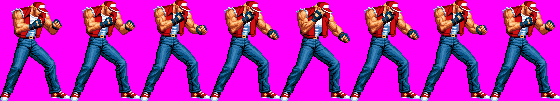

imagem 24bpp


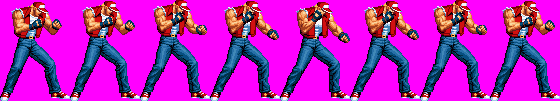

imagem 8bpp


In [5]:
#@title Modificar cor da palheta
#@markdown Para carregar palheta de arquivo selecione modificar e carregar_de_arquivo.
#@markdown O arquivo deve estar fora de todas as pastas e ter o nome **pal.png**.

#@markdown Para modificar uma cor especifica selecione o numero da cor de 0 a n-1
#@markdown e ajuste a cor nos cursores das componentes rgb
 


red = 0 #@param {type:"slider", min:0, max:255, step:1}
green = 0 #@param {type:"slider", min:0, max:255, step:1}
blue = 0 #@param {type:"slider", min:0, max:255, step:1}
index_pallet =  0#@param {type:"number"}
modificar = False #@param {type:"boolean"}
carregar_de_arquivo = False #@param {type:"boolean"}

#@markdown A palheta de cores original da imagem é mostrada abaixo:

unique, pal = get_pallet(final)
if modificar:
  if carregar_de_arquivo:
    pal_img = cv2.imread('/content/pal.png')
    unique_padrao, pal_padrao = get_pallet(pal_img)
    cv2_imshow(pal_padrao)
    if len(unique_padrao) <= len(unique):
      for i in range(len(unique_padrao)):
        final = modify_color(final, unique[i].tolist(), unique_padrao[i].tolist())
    else:
      for i in range(len(unique)):
        final = modify_color(final, unique[i].tolist(), unique_padrao[i].tolist())
  else:
    final = modify_color(final, unique[index_pallet].tolist(), [ blue, green , red])


cv2_imshow(pal)
save_result(final, arquivo_de_saida + '_24bpp', len(imgs_cropeds))
cv2_imshow(final)
print('imagem 24bpp')
display(save_8bpp(final, arquivo_de_saida+ '_8bpp'))
print('imagem 8bpp')

Script para testes

In [6]:
print('xmin = ' + str(xmin) + ' xmax = ' + str(xmax) + ' ymin = ' +
      str(ymin) +' ymax = ' + str(ymax))

print(count_colors(final))


xmin = 0 xmax = 72 ymin = -3 ymax = 101
16
